## Section 1. Parses all PCAP files

In [36]:
import dpkt
import time
import socket
import os
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, HTML
from multiprocessing import Pool

pd.options.display.float_format = '{:20.3f}'.format

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

### constants
g_dataDir = '../../iot_data/'
g_dataExtension = '.pcap'
g_testfile = '../../iot_data/16-09-27.pcap'
g_poolSize = 10
g_min_interval_seconds = 10
g_showprocess_count = 300000
g_timezone = 'AET' # They're in Sydney, Australia Eastern Time Zone
#columns = ['local_ip', 'local_port', 'remote_ip', 'remote_port', 'direction', 'len', 'seq', 'timestamp']
columns = ['len', 'timestamp']

### parse pcap files
### return: devices -> statistic category [tcp_total, tcp_in, tcp_out, tcp_empty_count] -> timeSections
def parsePcap(fileName):
    devices = {}
    file = open(fileName,'rb')
    for ts, pkt in dpkt.pcapng.Reader(file):
        eth = dpkt.ethernet.Ethernet(pkt)
        if eth.type != dpkt.ethernet.ETH_TYPE_IP:
            continue

        ip = eth.data
        if not hasattr(ip, 'p') or ip.p != dpkt.ip.IP_PROTO_TCP:
            continue

        # only tcp traffic is analyzed
        tcp = ip.data
        srcIp = socket.inet_ntoa(ip.src)
        dstIp = socket.inet_ntoa(ip.dst)
        if srcIp.startswith('192.168.'):
            localIp = srcIp
            localPort = tcp.sport
            remoteIp = dstIp
            remotePort = tcp.dport
            direction = 'out'
        else:
            localIp = dstIp
            localPort = tcp.dport
            remoteIp = srcIp
            remotePort = tcp.sport
            direction = 'in'

        # check if dataframe is created for this ip
        if localIp not in devices:
            devices[localIp] = {
                'tcp_total_KB': {},
                'tcp_in_KB': {},
                'tcp_out_KB': {},
                'tcp_empty_packet_count': {}
            }

        # save data to corresponding device's dataframe
        section = math.floor(ts / g_min_interval_seconds) * g_min_interval_seconds
        packetLen = len(tcp.data)
        for catKey in devices[localIp].keys():
            if section not in devices[localIp][catKey]:
                devices[localIp][catKey][section] = 0
            if catKey == 'tcp_total_KB' or (catKey == 'tcp_in_KB' and direction == 'in') or (catKey == 'tcp_out_KB' and direction == 'out'):
                devices[localIp][catKey][section] += packetLen / 1024
            if catKey == 'tcp_empty_packet_count' and packetLen == 0:
                devices[localIp][catKey][section] += 1
        # df.loc[df.shape[0]] = [localIp, localPort, remoteIp, remotePort, direction, len(tcp.data), tcp.seq, ts]
        
    print('Finished parsing: ' + fileName)
    return devices

def mergeDevice(d1, d2):
    for catKey in d2.keys():
        for key, value in d2[catKey].items():
            if key not in d1[catKey]:
                d1[catKey][key] = value
            else:
                d1[catKey][key] += value
    
### list files
dataFiles = []
for fileName in os.listdir(g_dataDir):
    if fileName.endswith(g_dataExtension):
        dataFiles.append(os.path.join(g_dataDir, fileName))

### send job to workers
pool = Pool(g_poolSize)
devicesArray = pool.map(parsePcap, dataFiles)

### merge results
devices = {}
for d in devicesArray:
    for dKey, dValue in d.items():
        if dKey not in devices:
            devices[dKey] = dValue
        else:
            mergeDevice(devices[dKey], dValue)

print("Parse completed for all files")


Finished parsing: ../../iot_data/16-09-25.pcap
Finished parsing: ../../iot_data/16-09-26.pcap
Finished parsing: ../../iot_data/16-10-08.pcap
Finished parsing: ../../iot_data/16-10-02.pcap
Finished parsing: ../../iot_data/16-09-29.pcap
Finished parsing: ../../iot_data/16-09-30.pcap
Finished parsing: ../../iot_data/16-09-24.pcap
Finished parsing: ../../iot_data/16-09-27.pcap
Finished parsing: ../../iot_data/16-10-06.pcap
Finished parsing: ../../iot_data/16-10-03.pcap
Finished parsing: ../../iot_data/16-10-09.pcap
Finished parsing: ../../iot_data/16-10-01.pcap
Finished parsing: ../../iot_data/16-10-07.pcap
Finished parsing: ../../iot_data/16-10-10.pcap
Finished parsing: ../../iot_data/16-09-23.pcap
Finished parsing: ../../iot_data/16-10-11.pcap
Finished parsing: ../../iot_data/16-10-05.pcap
Finished parsing: ../../iot_data/16-09-28.pcap
Finished parsing: ../../iot_data/16-10-04.pcap
Finished parsing: ../../iot_data/16-10-12.pcap
Parse completed for all files


## Section 2. Plot data

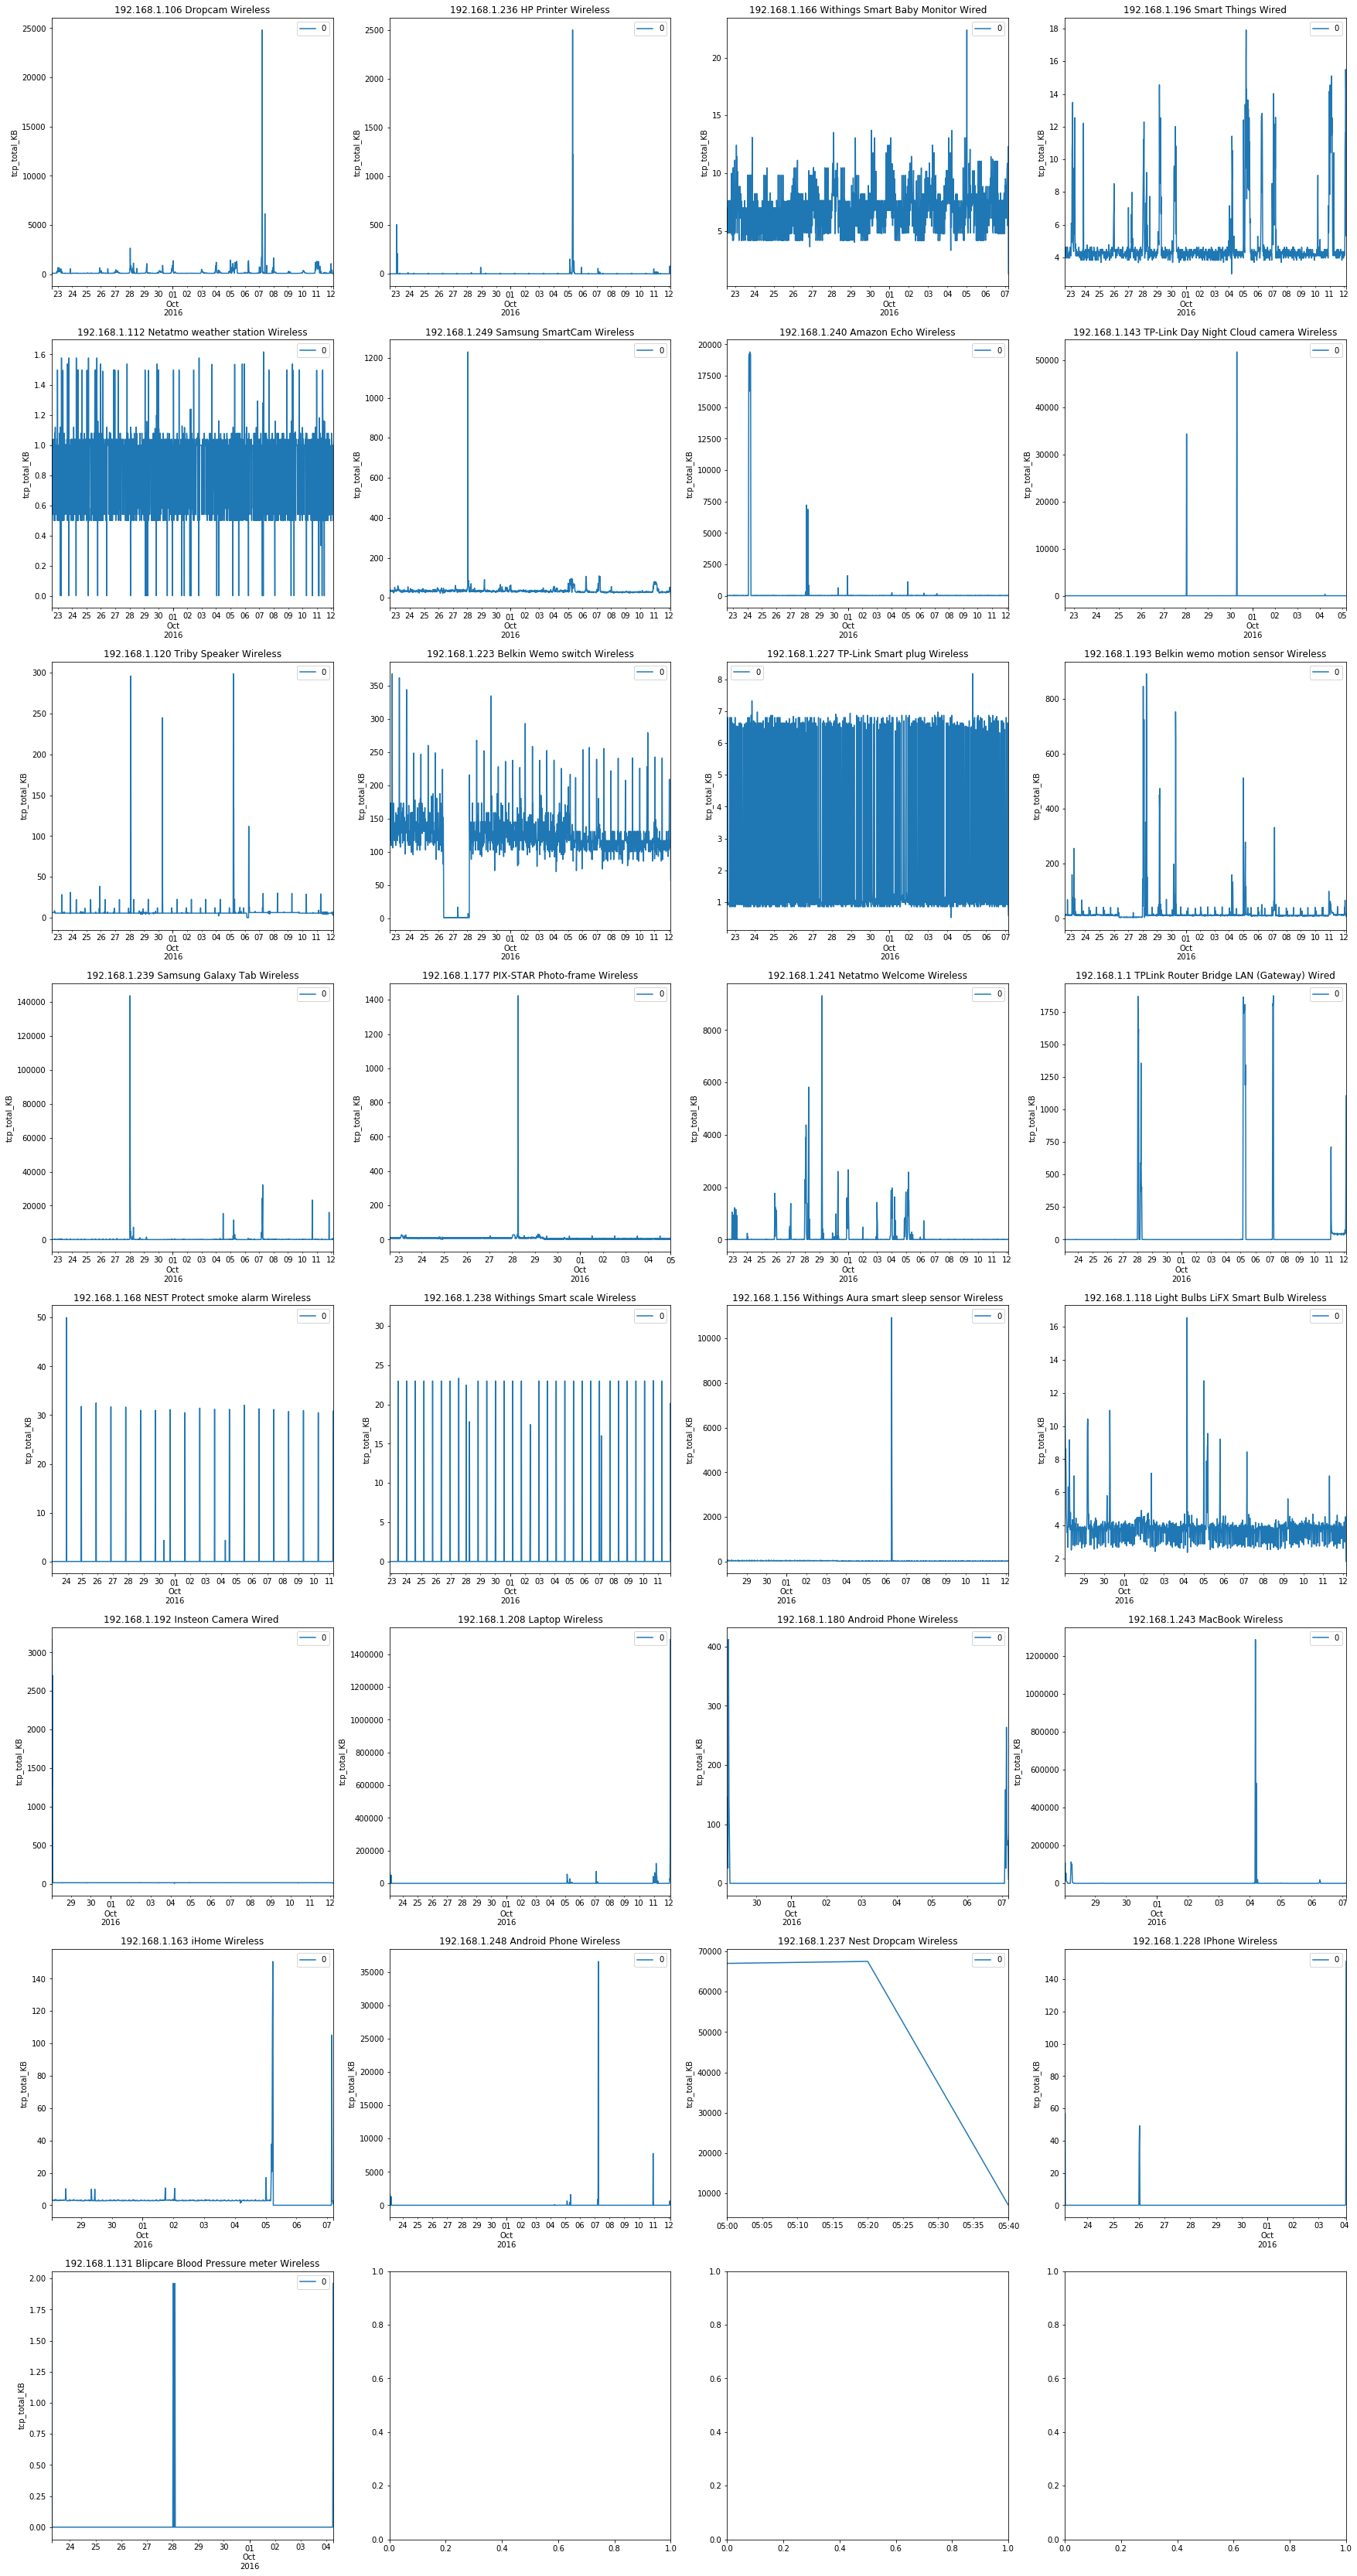

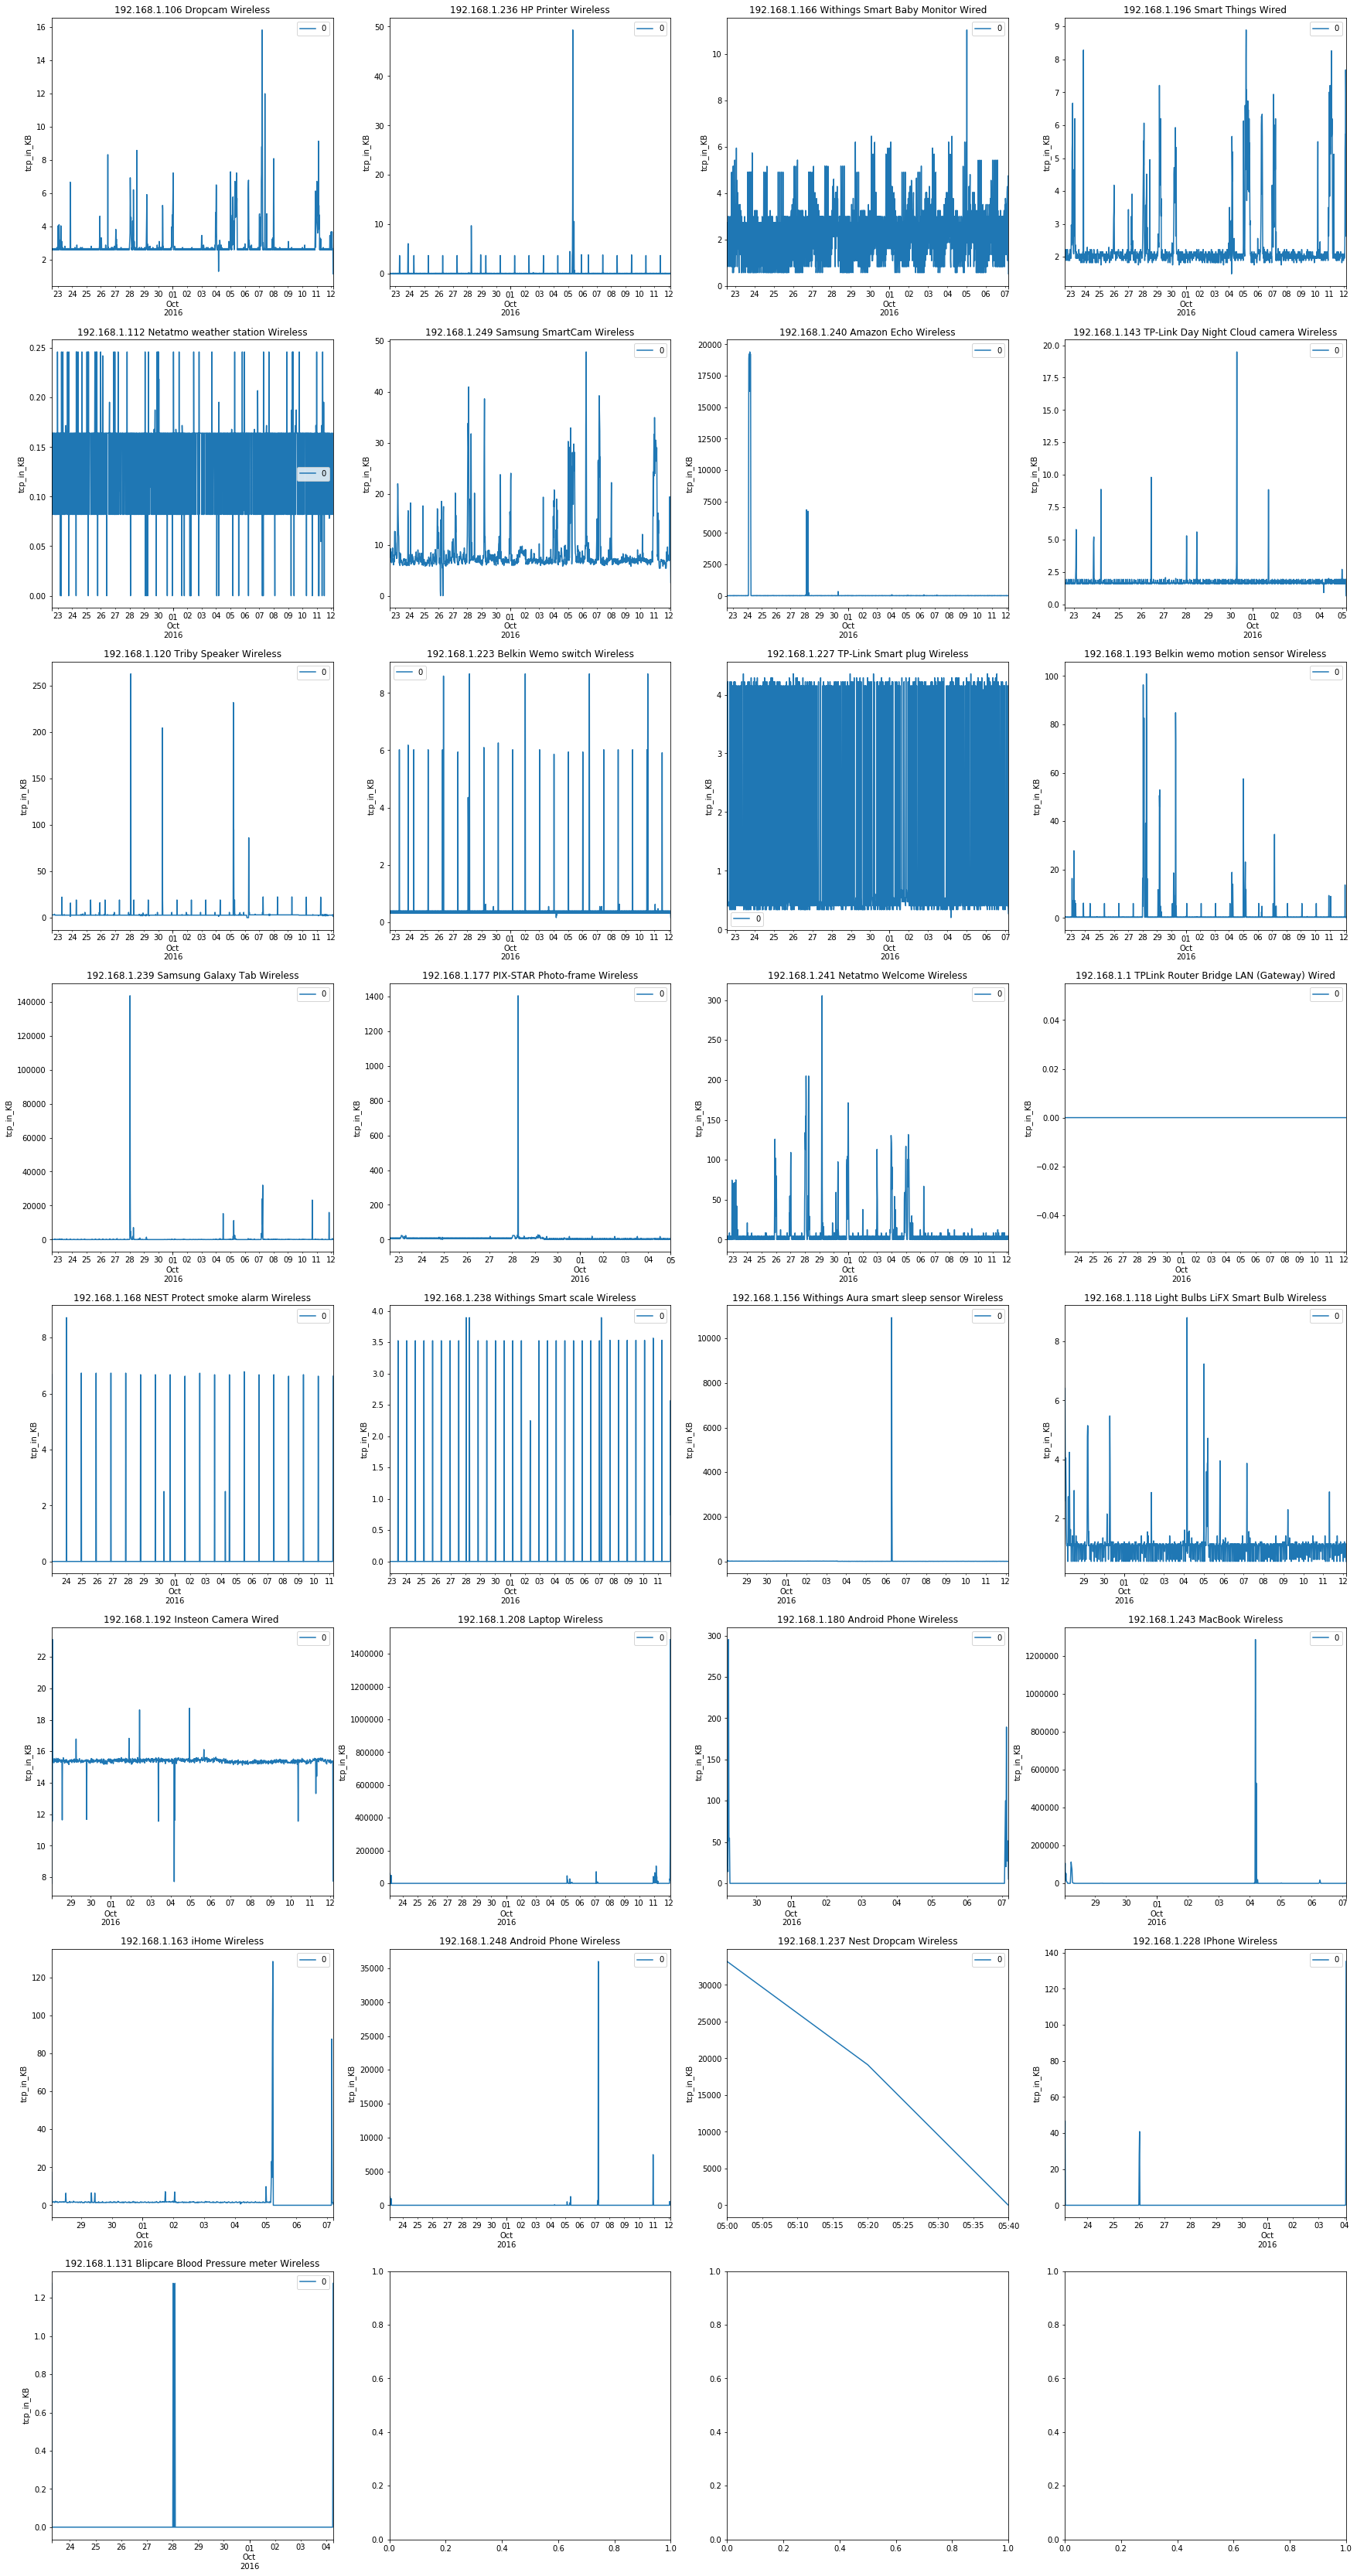

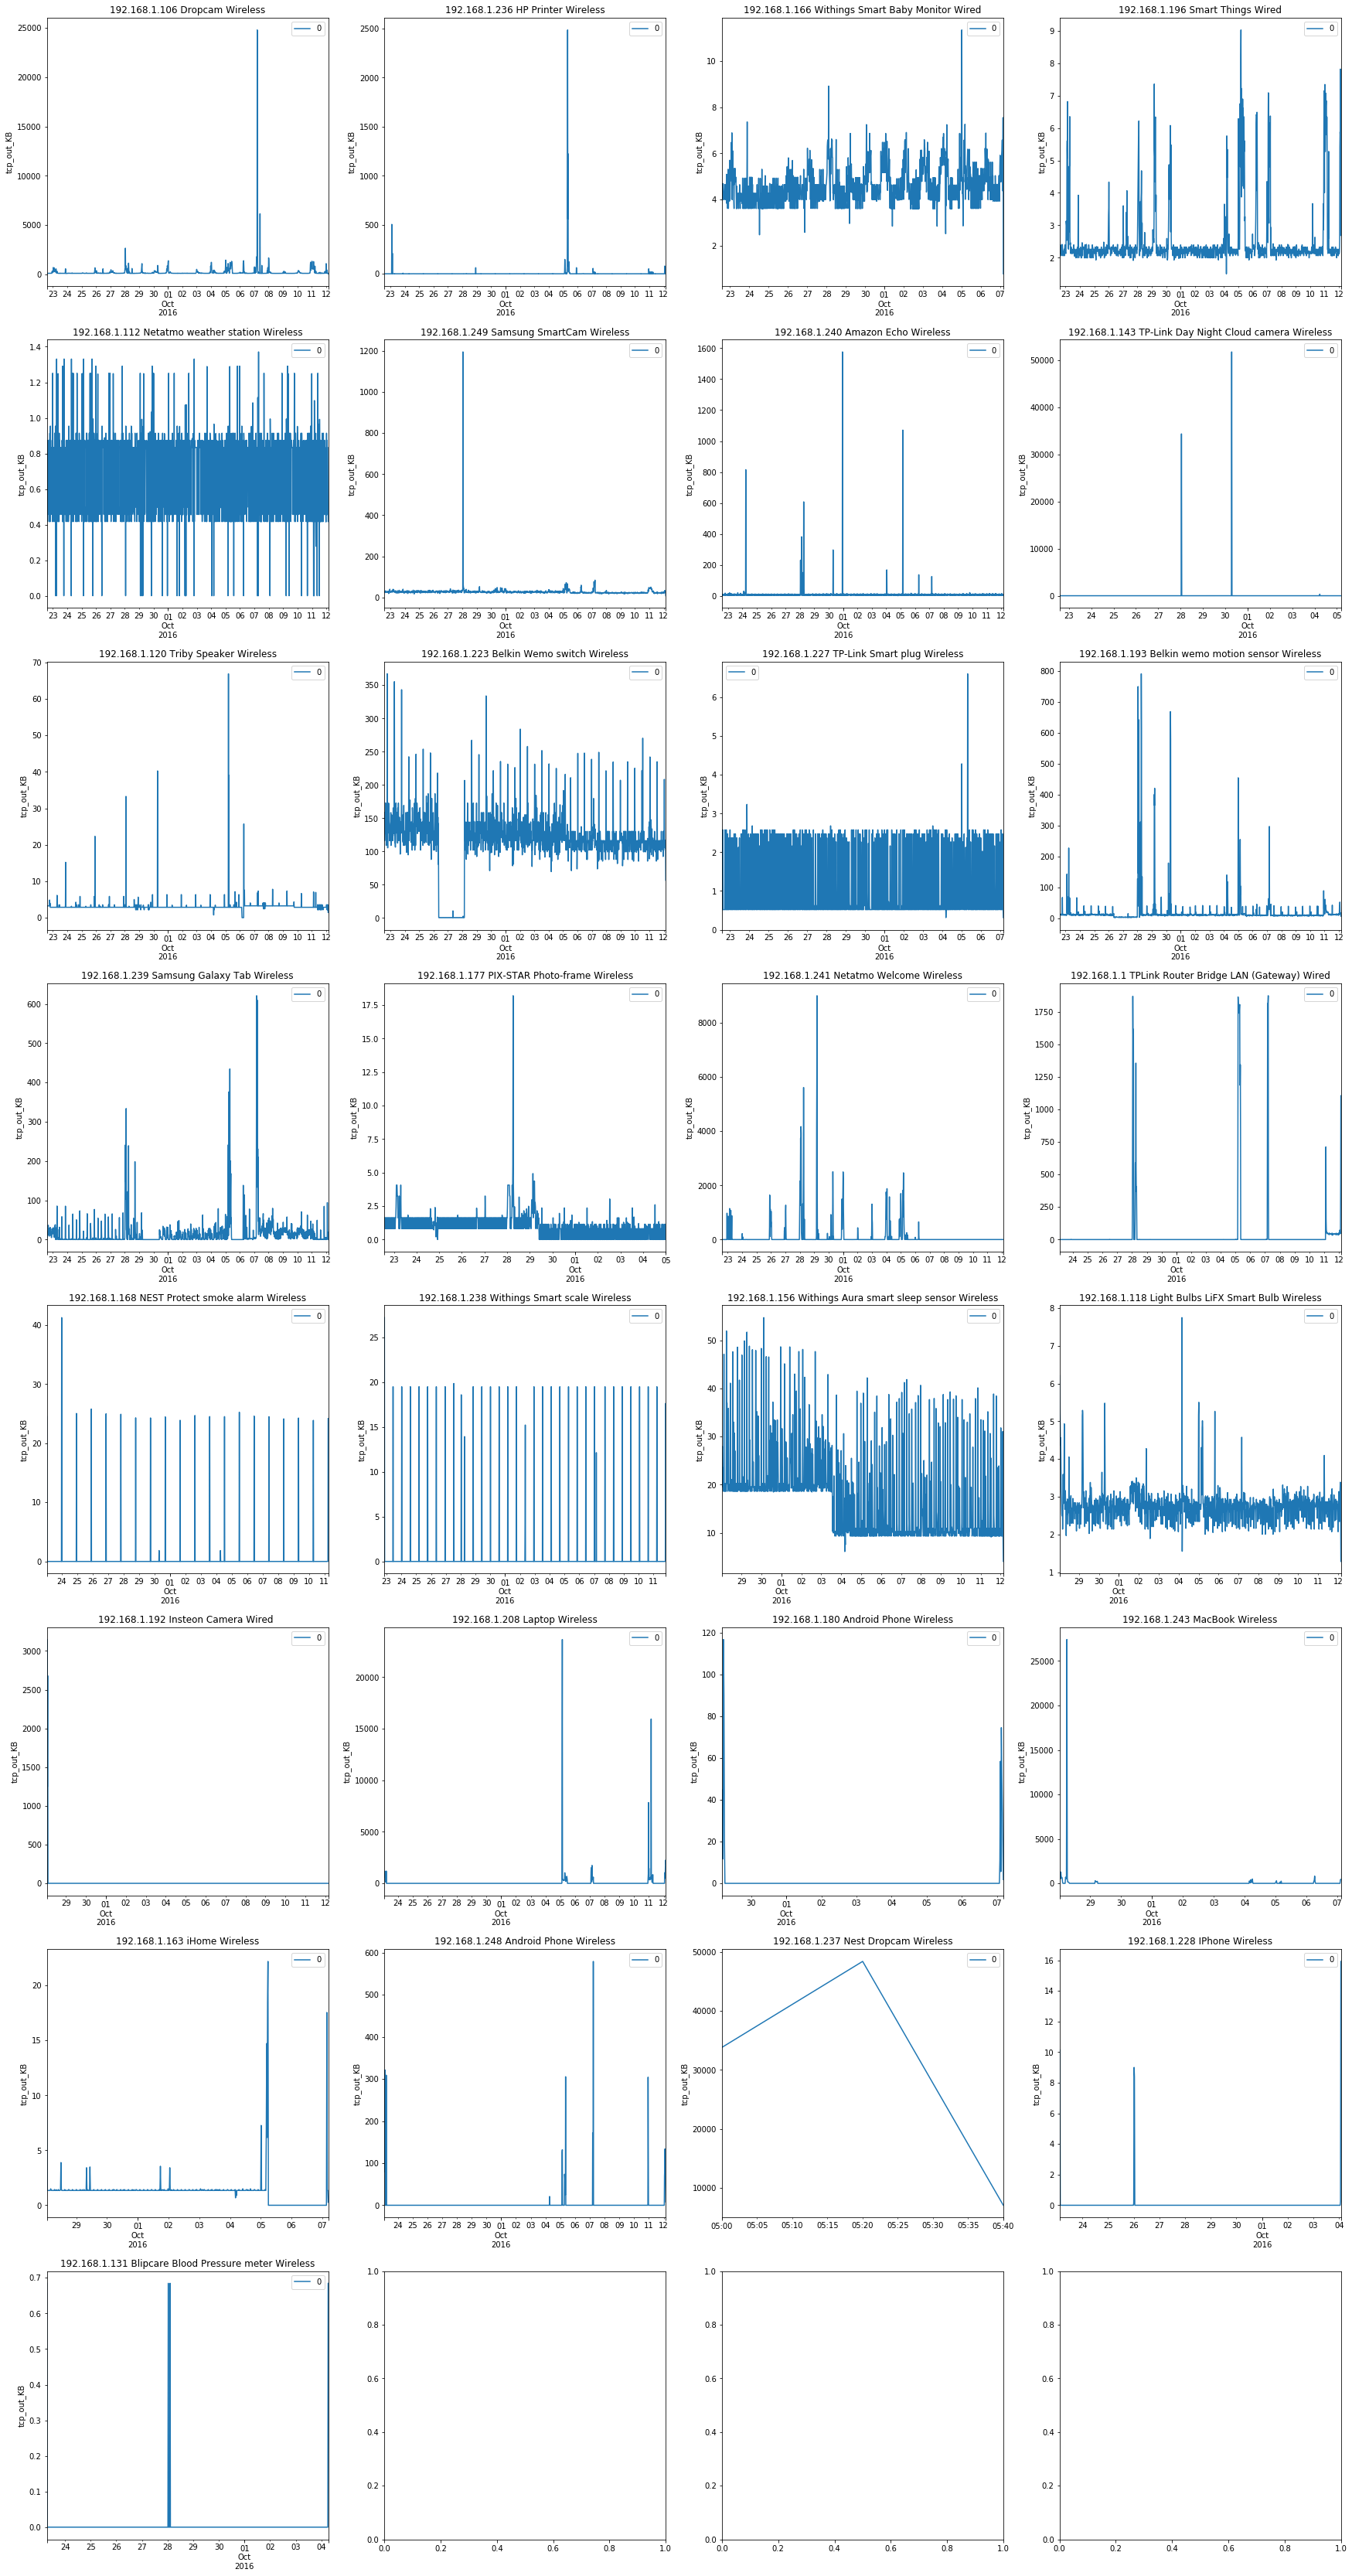

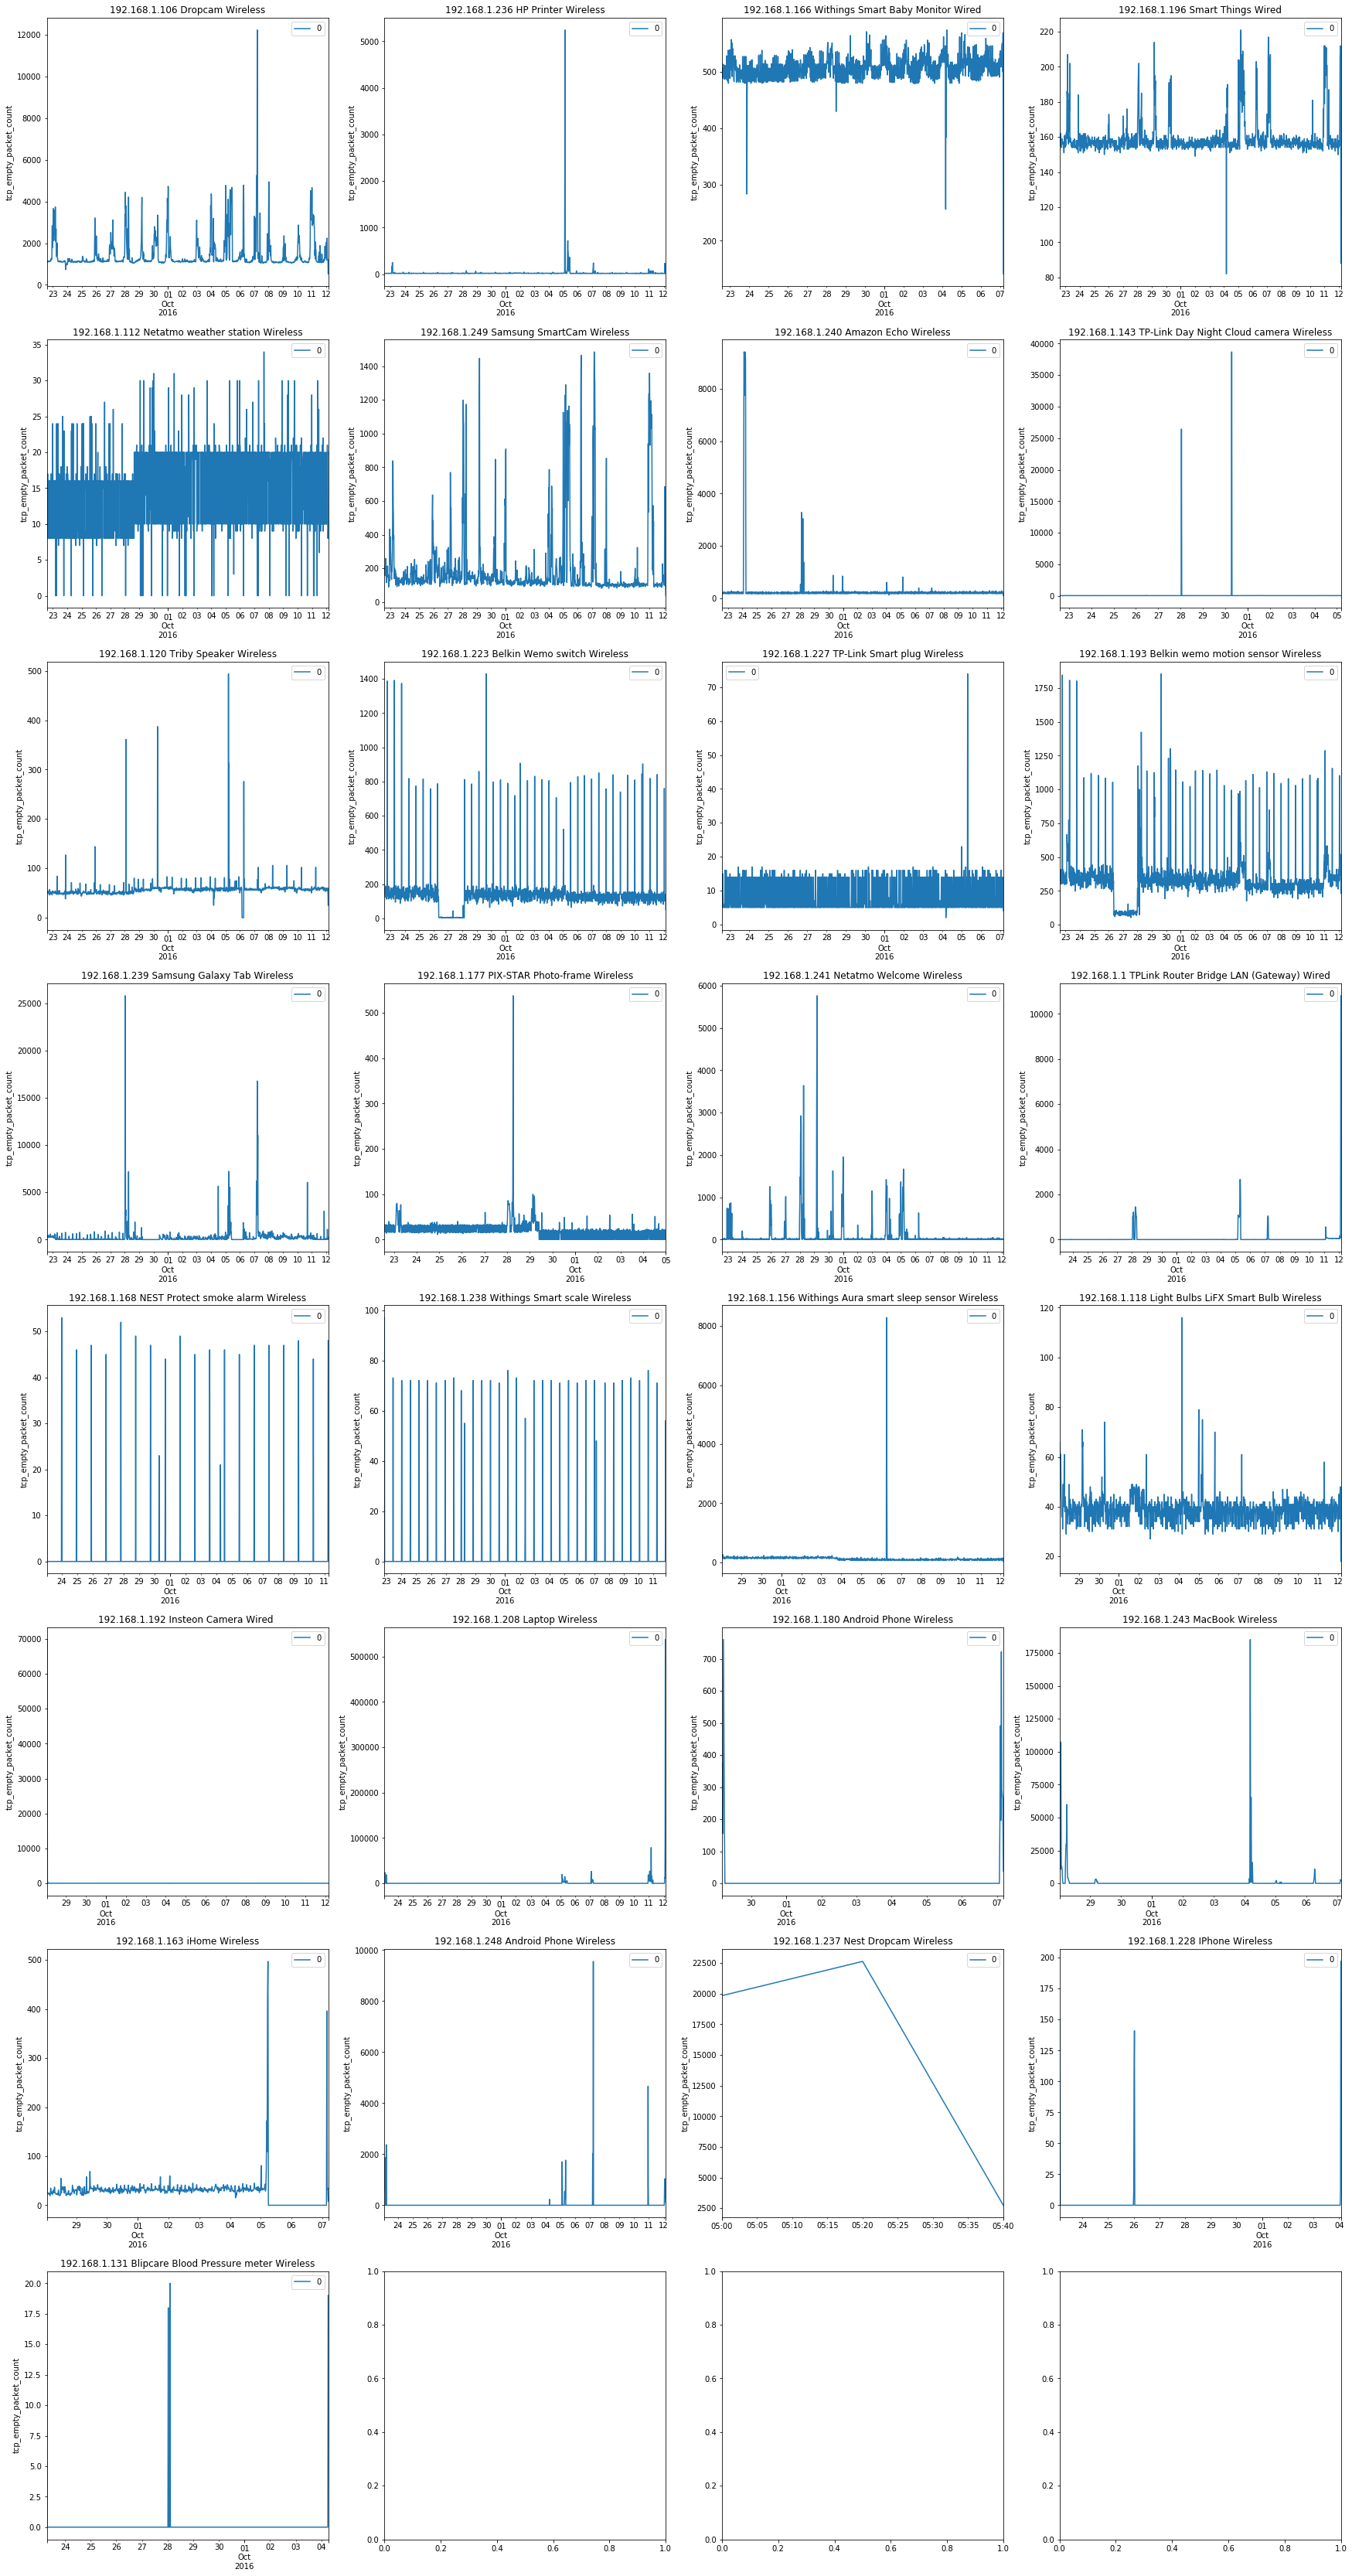

In [57]:
device_infos = {
    '192.168.1.1': ['TPLink Router Bridge LAN (Gateway) Wired', '14:cc:20:51:33:ea'],
    '192.168.1.106': ['Dropcam Wireless', '30:8c:fb:2f:e4:b2'],
    '192.168.1.112': ['Netatmo weather station Wireless', '70:ee:50:03:b8:ac'],
    '192.168.1.118': ['Light Bulbs LiFX Smart Bulb Wireless', 'd0:73:d5:01:83:08'],
    '192.168.1.120': ['Triby Speaker Wireless', '18:b7:9e:02:20:44'],
    '192.168.1.131': ['Blipcare Blood Pressure meter Wireless', '74:6a:89:00:2e:25'],
    '192.168.1.143': ['TP-Link Day Night Cloud camera Wireless', 'f4:f2:6d:93:51:f1'],
    '192.168.1.156': ['Withings Aura smart sleep sensor Wireless', '00:24:e4:20:28:c6'],
    '192.168.1.163': ['iHome Wireless', '74:c6:3b:29:d7:1d'],
    '192.168.1.166': ['Withings Smart Baby Monitor Wired', '00:24:e4:11:18:a8'],
    '192.168.1.168': ['NEST Protect smoke alarm Wireless', '18:b4:30:25:be:e4'],
    '192.168.1.177': ['PIX-STAR Photo-frame Wireless', 'e0:76:d0:33:bb:85'],
    '192.168.1.180': ['Android Phone Wireless', '40:f3:08:ff:1e:da'],
    '192.168.1.192': ['Insteon Camera Wired ', '00:62:6e:51:27:2e'],
    '192.168.1.193': ['Belkin wemo motion sensor Wireless', 'ec:1a:59:83:28:11'],
    '192.168.1.196': ['Smart Things Wired', 'd0:52:a8:00:67:5e'],
    '192.168.1.208': ['Laptop Wireless', '74:2f:68:81:69:42'],
    '192.168.1.223': ['Belkin Wemo switch Wireless', 'ec:1a:59:79:f4:89'],
    '192.168.1.227': ['TP-Link Smart plug Wireless', '50:c7:bf:00:56:39'],
    '192.168.1.228': ['IPhone Wireless', 'd0:a6:37:df:a1:e1'],
    '192.168.1.236': ['HP Printer Wireless', '70:5a:0f:e4:9b:c0'],
    '192.168.1.237': ['Nest Dropcam Wireless', '30:8c:fb:b6:ea:45'],
    '192.168.1.238': ['Withings Smart scale Wireless', '00:24:e4:1b:6f:96'],
    '192.168.1.239': ['Samsung Galaxy Tab Wireless', '08:21:ef:3b:fc:e3'],
    '192.168.1.240': ['Amazon Echo Wireless', '44:65:0d:56:cc:d3'],
    '192.168.1.241': ['Netatmo Welcome Wireless', '70:ee:50:18:34:43'],
    '192.168.1.243': ['MacBook Wireless', 'ac:bc:32:d4:6f:2f'],
    '192.168.1.248': ['Android Phone Wireless', 'b4:ce:f6:a7:a3:c2'],
    '192.168.1.249': ['Samsung SmartCam Wireless', '00:16:6c:ab:6b:88']
    #'192.168.1.42': ['Laptop Wireless', '74:2f:68:81:69:42']
}
    
g_plot_freq = '20Min'
g_plot_columns = 4   # 3 sub plots per row
g_plot_outputDir = '../../iot_output/'

def drawPlot(category):
    deviceCount = sum(1 for devIp in devices.keys() if devIp in device_infos)
    rowCount = math.ceil(deviceCount/g_plot_columns)
    colCount = g_plot_columns
    fig, axes = plt.subplots(nrows=rowCount, ncols=colCount, figsize=(30, 30 * rowCount / colCount))
    plotIndex = 0
    for devIp, devData in devices.items():
        if devIp not in device_infos:
            continue
        df = pd.DataFrame.from_dict(devData[category], orient='index')
        df.index = pd.to_datetime(df.index, unit='s')
        df2 = df.groupby(pd.Grouper(freq=g_plot_freq)).sum()
        ax = df2.plot(title=devIp + ' ' + device_infos[devIp][0], ax=axes[math.floor(plotIndex / g_plot_columns), plotIndex % g_plot_columns])
        ax.set_ylabel(category)
        plotIndex += 1
    plt.savefig(g_plot_outputDir + category + '.jpg', bbox_inches='tight')

for cat in list(devices.values())[0].keys():
    drawPlot(cat)
    